In [3]:
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(stringr))
library(reshape2)
library(plyr)
library(purrr)
library(parallel)
library(Seurat)
library(MASS)
library(metR)
library(hise)
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(SeuratDisk))
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(H5weaver))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(patchwork))


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



Attaching package: ‘purrr’


The following object is masked from ‘package:plyr’:

    compact


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package

In [4]:
install.packages('ggplot2')

Installing package into ‘/home/jupyter/libb’
(as ‘lib’ is unspecified)



In [5]:
col_vector<-c('#FDC086','#FFFF99','#F0027F','#BF5B17','#666666',
          '#1B9E77','#D95F02','#7570B3','#E7298A','#66A61E','#E6AB02','#A6761D','#666666',
          '#A6CEE3','#1F78B4','#B2DF8A','#33A02C','#FB9A99','#E31A1C','#FDBF6F','#FF7F00',
          '#CAB2D6','#6A3D9A','#FFFF99','#B15928','#FBB4AE','#B3CDE3','#CCEBC5','#DECBE4',
          '#FED9A6','#FFFFCC','#E5D8BD','#FDDAEC','#F2F2F2','#B3E2CD','#FDCDAC','#CBD5E8',
          '#F4CAE4','#E6F5C9','#FFF2AE','#F1E2CC','#CCCCCC','#E41A1C','#377EB8','#4DAF4A',
          '#984EA3','#FF7F00','#FFFF33','#A65628','#F781BF','#999999','#66C2A5','#FC8D62',
          '#8DA0CB','#E78AC3','#A6D854','#FFD92F','#E5C494','#B3B3B3','#8DD3C7','#FFFFB3',
          '#BEBADA','#FB8072','#80B1D3','#FDB462','#B3DE69','#FCCDE5','#D9D9D9','#BC80BD',
          '#CCEBC5','#FFED6F')

In [6]:
library(MASS)
library(metR)

In [7]:
density_map<-function (df,lvls=NULL,title=NULL){
#df<-data.frame(seurat_object@reductions$umap@cell.embeddings)
#add extra space on umap
extra_umap_space<-1
#calculate density

density<-kde2d(df$UMAP_1,df$UMAP_2,n=100,lims = c(min(df$UMAP_1)-extra_umap_space, max(df$UMAP_1)+extra_umap_space, min(df$UMAP_2)-extra_umap_space, max(df$UMAP_2)+extra_umap_space))

#refomat output to get density at each pixel
volcano3d <- melt(density$z)

#get coord
x_cord<-rep(density$x, 100)
y_cord<-NULL

for (z in density$y){
y_cord<-c(y_cord,rep(z,100))
}

names(volcano3d) <- c("x", "y", "z")
volcano3d$x<-x_cord
volcano3d$y<-y_cord

#define the number of scales
if (is.null(lvls)){
estimate_lvls<-density$z
lvls <- pretty(range(estimate_lvls),20)
}
#make the plot
p<-ggplot(volcano3d, aes(x, y, z = z)) + geom_contour_filled(geom="polygon", aes(fill=..level..),breaks=lvls) +
    scale_fill_gradientn(colours = c('white','lightblue2','lightblue4','blue','blue1','blue2','yellow1','yellow2','yellow3','red1','red2','red3','red4','darkred'),super = metR::ScaleDiscretised,)+
    theme(axis.title.x=element_blank(),axis.title.y=element_blank(),
        axis.text.x=element_blank(),axis.text.y=element_blank(),axis.ticks.y=element_blank(),
        axis.ticks.x=element_blank(),panel.grid=element_blank(),legend.key.size = unit(3, 'cm'),legend.text=element_text(size=15))#+ 
    #xlab("UMAP_1") + 
    #ylab("UMAP_2")+ggtitle(title)
return (list(p,lvls,volcano3d,density))

}

In [8]:
fileDescToDataframe_beta <- function(descriptors,
                                keep_labs = FALSE) {
  descriptors<-descriptors[[1]]
  assertthat::assert_that(typeof(descriptors) == "list")
  assertthat::assert_that(typeof(keep_labs) == "logical")
  
  do.call(
    rbind.fill,
    lapply(
      descriptors,
      function(desc) {
        desc <- unlist(desc)
        desc <- desc[!grepl("scheme", names(desc))]
        names(desc) <- sub("^descriptors.","",names(desc))
        desc <- desc[!grepl("^specimens", names(desc))]
        desc <- desc[!grepl("^lab", names(desc))]
        desc <- desc[!grepl("^emr", names(desc))]
        desc <- desc[!grepl("^survey", names(desc))]
        desc <- desc[!grepl("^revision", names(desc))]
        desc <- desc[!grepl("^file.userTags", names(desc))]
        desc <- as.list(desc)
        df <- as.data.frame(desc)
        df
      }
    )
  )
}

fileDescToDataframe <- function(descriptors,
                                keep_labs = FALSE) {
  
  assertthat::assert_that(typeof(descriptors) == "list")
  assertthat::assert_that(typeof(keep_labs) == "logical")
  
  do.call(
    rbind,
    lapply(
      descriptors,
      function(desc) {
        desc <- unlist(desc)
        desc <- desc[!grepl("scheme", names(desc))]
        names(desc) <- sub("^descriptors.","",names(desc))
        desc <- desc[!grepl("^specimens", names(desc))]
        desc <- desc[!grepl("^lab", names(desc))]
        desc <- desc[!grepl("^emr", names(desc))]
        desc <- desc[!grepl("^survey", names(desc))]
        desc <- desc[!grepl("^revision", names(desc))]
        desc <- desc[!grepl("^file.userTags", names(desc))]

        desc <- as.list(desc)
        df <- as.data.frame(desc)
        df
      }
    )
  )
}
get_last_pattern <- function(x) {
  split_vector <- strsplit(x, "/")[[1]]
  last_pattern <- tail(split_vector, 1)
  return(last_pattern)
}


# Donwload Data

In [9]:
hise_meta<-read.csv("/home/jupyter/BRI_Analysis/scRNA/meta_data_2024-01-16_fixed.csv")
last_patterns <- unlist(lapply(hise_meta$file.name, get_last_pattern))
hise_meta$file.path<-paste0("cache/",hise_meta$file.id,"/",last_patterns)
hise_meta$batch_pool<-substr(hise_meta$file.path,44,50)

In [ ]:
IMM_filter_list <- list(
    sample.bridgingControl="true")
IMM_rna_desc <- getFileDescriptors(
    fileType = "scRNA-seq-labeled", 
    filter = IMM_filter_list)

In [ ]:
IMM_rna_desc <- fileDescToDataframe_beta(IMM_rna_desc)
IMM_rna_desc<-IMM_rna_desc %>% filter(!grepl("EXP",file.name))

In [ ]:
IMM_rna_desc$batch_pool<-paste0("B",substr(sub(".*B", "", IMM_rna_desc$file.name),1,6))


In [ ]:
IMM_file_path<-as.data.frame(list.files(path = "cache", pattern = "h5", all.files = TRUE,
           full.names = TRUE, recursive = TRUE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE))
colnames(IMM_file_path)<-"file.path"


In [ ]:
IMM_file_path$file.id<-unlist(lapply(IMM_file_path,function(x){str_match(x, "/([^/]+)/")[,2]}))

In [ ]:
IMM_rna_desc_subset<-IMM_rna_desc %>% filter(!file.id%in% IMM_file_path$file.id)

In [ ]:
IMM_meta_data_scRNA_list<-list()
for (i in 1:dim(IMM_rna_desc_subset)[1]){
meta_data_scRNA_IMM <- cacheFiles(list(IMM_rna_desc_subset$file.id[i]))
print (i)
}

In [ ]:
IMM_rna_desc_subset<-left_join(IMM_rna_desc_subset,IMM_file_path)

In [ ]:
IMM_rna_desc_subset$batch_pool<-paste0("B",substr(sub(".*B", "", IMM_rna_desc_subset$file.path),1,6))

In [ ]:
IMM_rna_desc_subset<-IMM_rna_desc_subset %>% filter(batch_pool%in% unique(hise_meta$batch_pool))

# Combine data

In [ ]:
so_list <- lapply(IMM_rna_desc_subset$file.path, H5weaver::read_h5_seurat, target = "matrix", feature_names = "name")

In [ ]:
b <- seq(10, length(so_list)[1]+9, 10)
df_chunk_list<-lapply(seq_along(b), function(i) so_list[(b-9)[i]:b[i] ])    
    
so_list_subcombined<-mclapply(df_chunk_list, function(x){

x[sapply(x, is.null)] <- NULL

combined<-Reduce(merge, x)

},mc.cores=2)    

                   

In [ ]:
combined<-Reduce(merge, so_list_subcombined)


In [ ]:
combined[["percent.mt"]] <- PercentageFeatureSet(combined, pattern = "^MT-")
combined <- subset(combined, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 10)
combined <- NormalizeData(combined)
combined <- FindVariableFeatures(combined, selection.method = "vst", nfeatures = 3000)
combined <- ScaleData(combined)
combined <- RunPCA(combined, features = VariableFeatures(object = combined))
combined <- FindNeighbors(combined, dims = 1:30)
combined <- FindClusters(combined, resolution = 0.5)
combined <- RunUMAP(combined, dims = 1:30)


In [ ]:
saveRDS(combined,paste0("IMM_SO_",Sys.Date(),".RDS"))

In [ ]:
combined<-readRDS("IMM_SO_2024-01-18.RDS")

In [ ]:
write.csv(sort(unique(combined[[]]$pool_id)),"pool_id_BR1.csv")

In [43]:
library(RColorBrewer)
colourCount = length(unique(combined[[]]$pool_id))
n <- colourCount
set.seed(321)
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

# Violin Plot

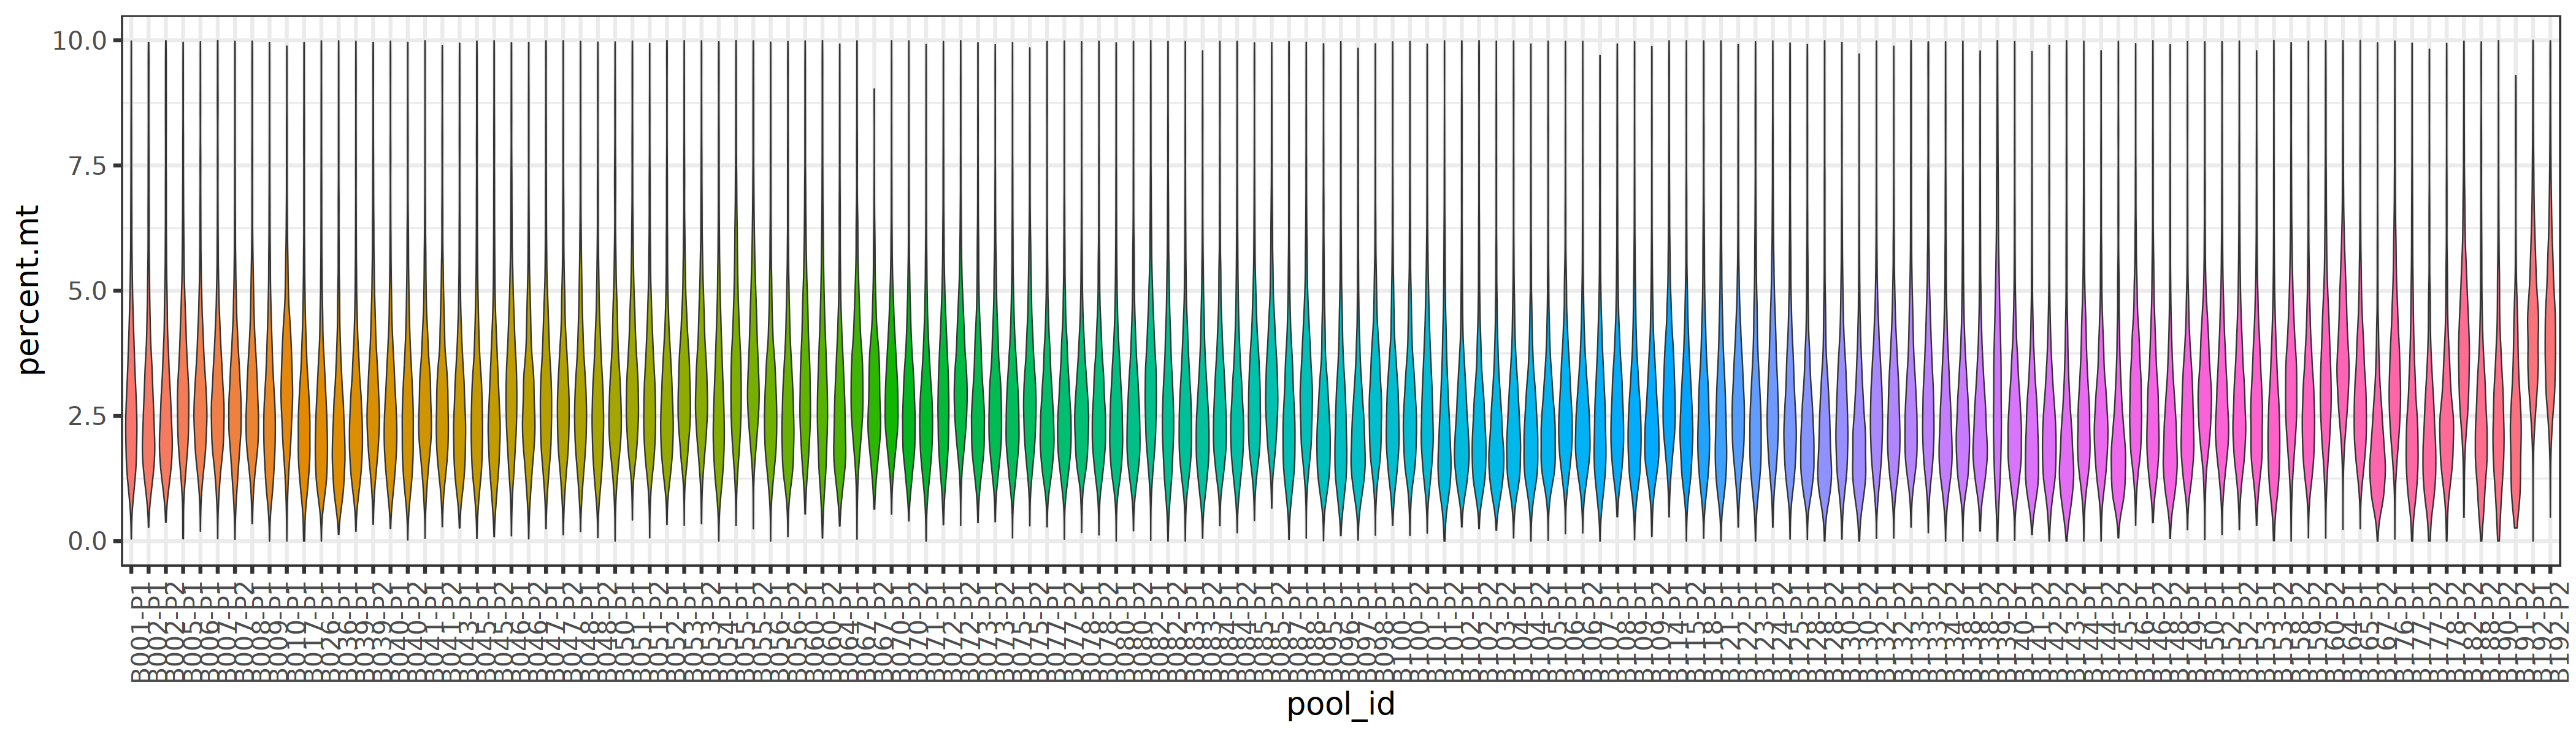

In [44]:
options(repr.plot.width = 35, repr.plot.height = 10)

p<-ggplot(combined[[]]%>% filter(percent.mt<10), aes(x=pool_id, y=percent.mt, fill=pool_id)) +
  geom_violin(trim=TRUE)+ theme_bw(base_size=30)+theme(axis.text.x = element_text(angle=90, hjust=1))+ guides(fill="none")
p
ggsave("01_QC_MT_Violion.png",p,width=35, height=10)

# UMAP

In [45]:
n_distinct(combined[[]]$pool_id)

[1] 141

In [46]:
n_distinct(combined[[]]$batch_id)

[1] 98

In [63]:
combined

An object of class Seurat 
33538 features across 578986 samples within 1 assay 
Active assay: RNA (33538 features, 3000 variable features)
 2 dimensional reductions calculated: pca, umap

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



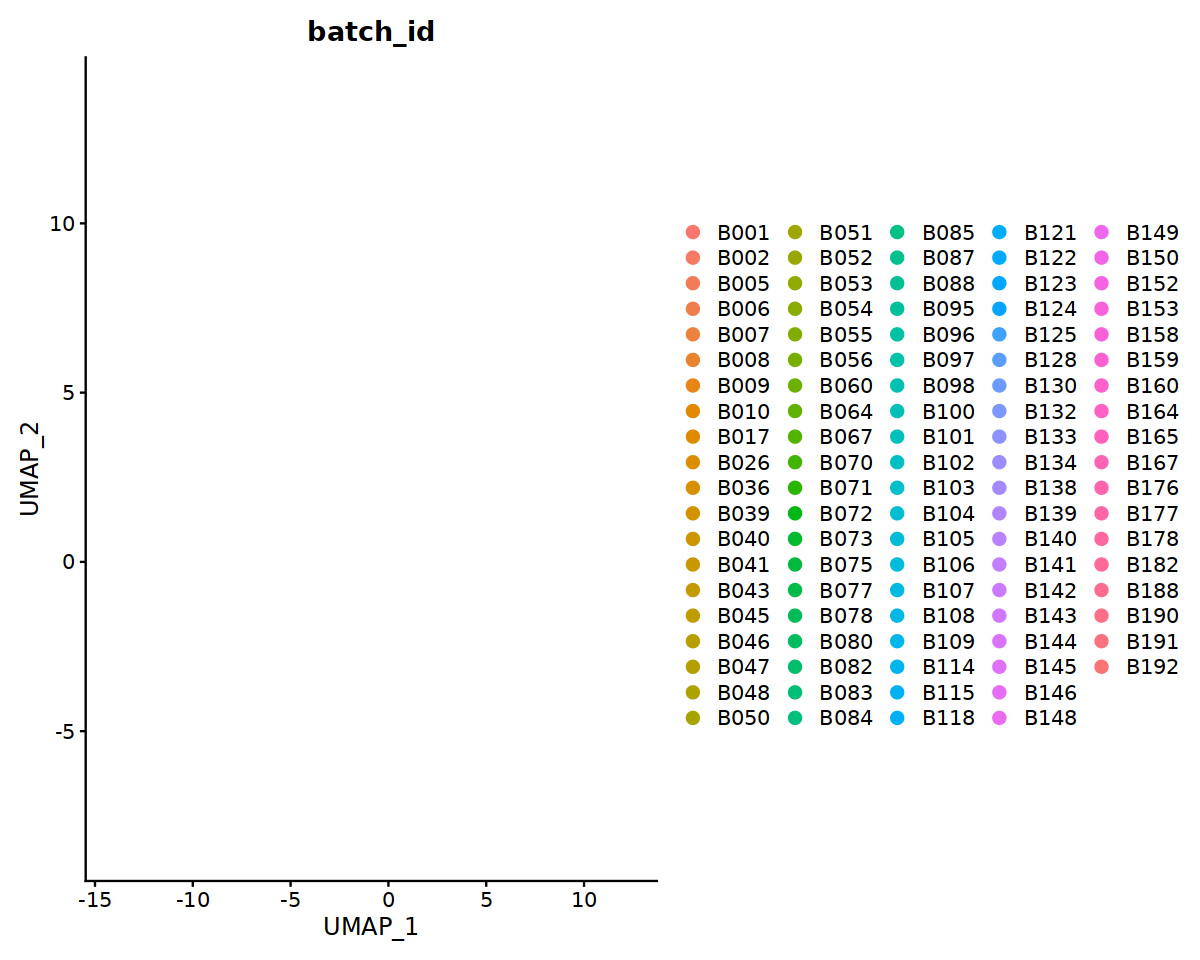

In [67]:
options(repr.plot.width = 10, repr.plot.height = 8)

DimPlot(combined, group.by="batch_id",reduction = "umap")



Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



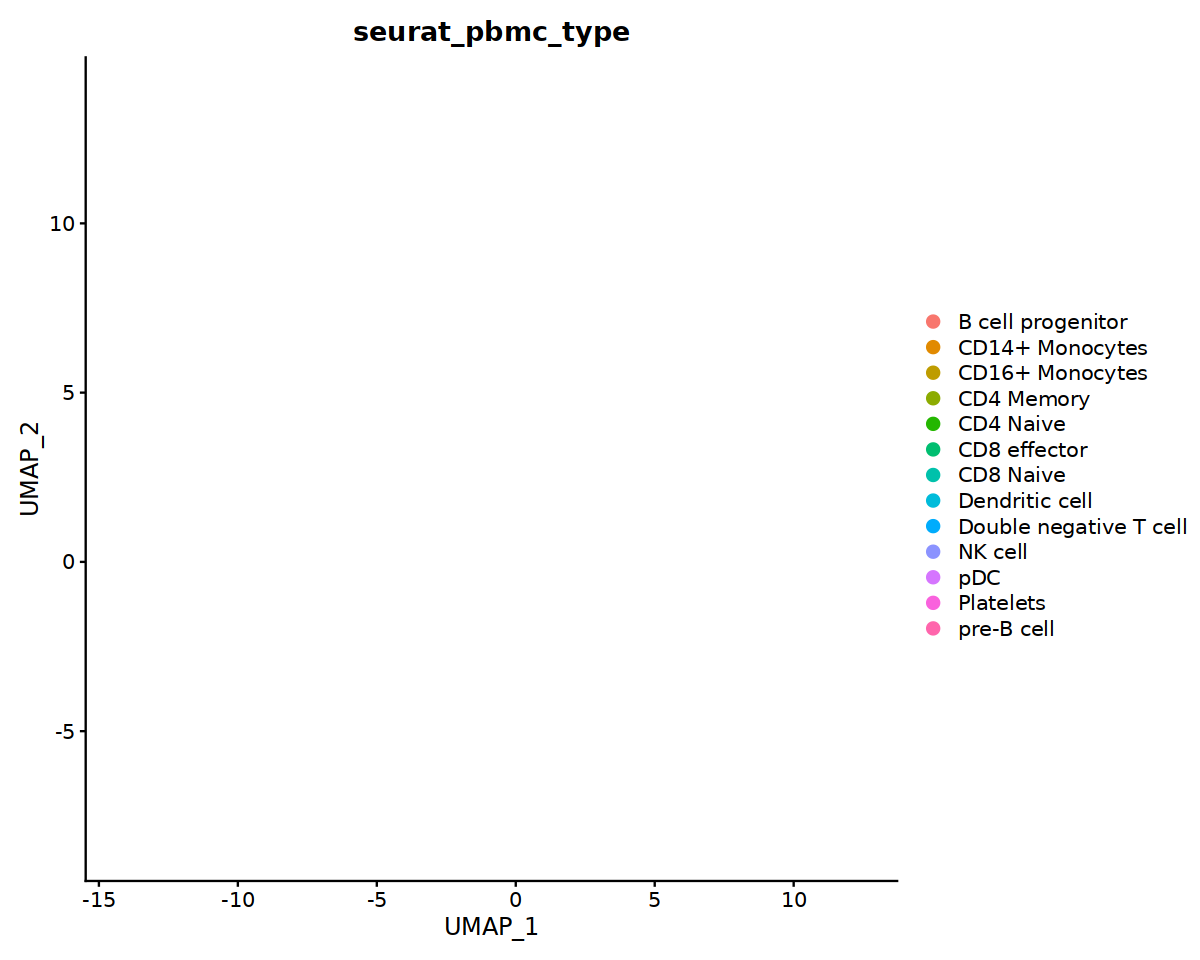

In [49]:
options(repr.plot.width = 10, repr.plot.height = 8)

p<-DimPlot(combined, group.by="seurat_pbmc_type",reduction = "umap")
p
ggsave("celltype_pbmc.png",p,width=10,height=8)

# Density plot

In [50]:
library(reshape2) 


In [51]:
df_UMAP<-cbind(combined[[]],combined@reductions$umap@cell.embeddings)



In [52]:
density<-lapply(sort(unique(df_UMAP$pool_id)),function(i) {
print(i)
density_sub<-density_map(df_UMAP %>% filter(pool_id==i))[[4]]
return(density_sub)
})


[1] "B001-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B002-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B002-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B005-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B006-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B007-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B007-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B008-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B009-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B010-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B017-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B026-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B036-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B039-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B039-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B040-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B040-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B041-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B041-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B043-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B045-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B045-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B046-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B046-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B047-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B047-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B048-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B048-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B050-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B051-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B051-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B052-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B053-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B053-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B054-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B055-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B055-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B056-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B056-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B060-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B060-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B064-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B067-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B067-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B070-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B070-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B071-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B072-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B072-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B073-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B073-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B075-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B075-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B077-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B077-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B078-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B078-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B080-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B080-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B082-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B082-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B083-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B083-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B084-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B084-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B085-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B085-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B087-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B088-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B095-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B096-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B097-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B098-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B100-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B100-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B101-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B101-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B102-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B102-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B103-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B104-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B104-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B105-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B106-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B106-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B107-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B108-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B109-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B109-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B114-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B115-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B118-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B121-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B122-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B123-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B124-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B125-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B128-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B128-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B130-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B130-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B132-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B132-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B133-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B133-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B134-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B138-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B138-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B139-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B140-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B141-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B142-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B143-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B144-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B144-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B145-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B146-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B146-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B148-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B149-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B150-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B152-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B152-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B153-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B153-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B158-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B159-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B160-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B164-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B165-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B167-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B176-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B177-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B177-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B178-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B182-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B188-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B190-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B191-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B192-P1"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


[1] "B192-P2"


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


In [53]:
average_density<-density_map(df_UMAP)[[4]]


Warning message in melt(density$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”


In [54]:
for (i in 1:length(density)){
density[[i]]$z<-density[[i]]$z-average_density$z
}

In [55]:
max_l<-c()
min_l<-c()
for (i in 1:length(density)){
max_l[i]<-max(density[[i]]$z)
min_l[i]<-max(density[[i]]$z)

}

In [56]:
lvls<-pretty(range(-max(max(max_l),-min(min_l)),max(max(max_l),-min(min_l))),20)

In [57]:
p<-list()
for (i in 1:n_distinct(df_UMAP$pool_id)){
    
volcano3d <- melt(density[[i]]$z)

x_cord<-rep(density[[i]]$x, 100)
y_cord<-NULL

for (z in density[[i]]$y){
y_cord<-c(y_cord,rep(z,100))
}

names(volcano3d) <- c("x", "y", "z")
volcano3d$x<-x_cord
volcano3d$y<-y_cord

#make the plot
p[[i]]<-ggplot(volcano3d, aes(x, y, z = z)) + geom_contour_filled(geom="polygon", aes(fill=..level..),breaks=lvls) +
    scale_fill_gradientn(colours = c('blue2','lightblue4','lightblue3','lightblue2',"white","white","pink",'red1','red2','red3'),super = metR::ScaleDiscretised,)+
    theme(panel.grid=element_blank(),legend.key.size = unit(3, 'cm'),legend.text=element_text(size=15))+ 
    xlab("UMAP_1") + 
    ylab("UMAP_2")+ggtitle(sort(unique(df_UMAP$pool_id))[i])
}


Warning message in melt(density[[i]]$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density[[i]]$z). In the next version, this warning will become an error.”
Warning message in geom_contour_filled(geom = "polygon", aes(fill = ..level..), :
“Ignoring unknown parameters: `geom`”
Warning message in melt(density[[i]]$z):
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(density[[i]]$z).

Warning message:
“The dot-dot notation (`..level..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(level)` instead.”


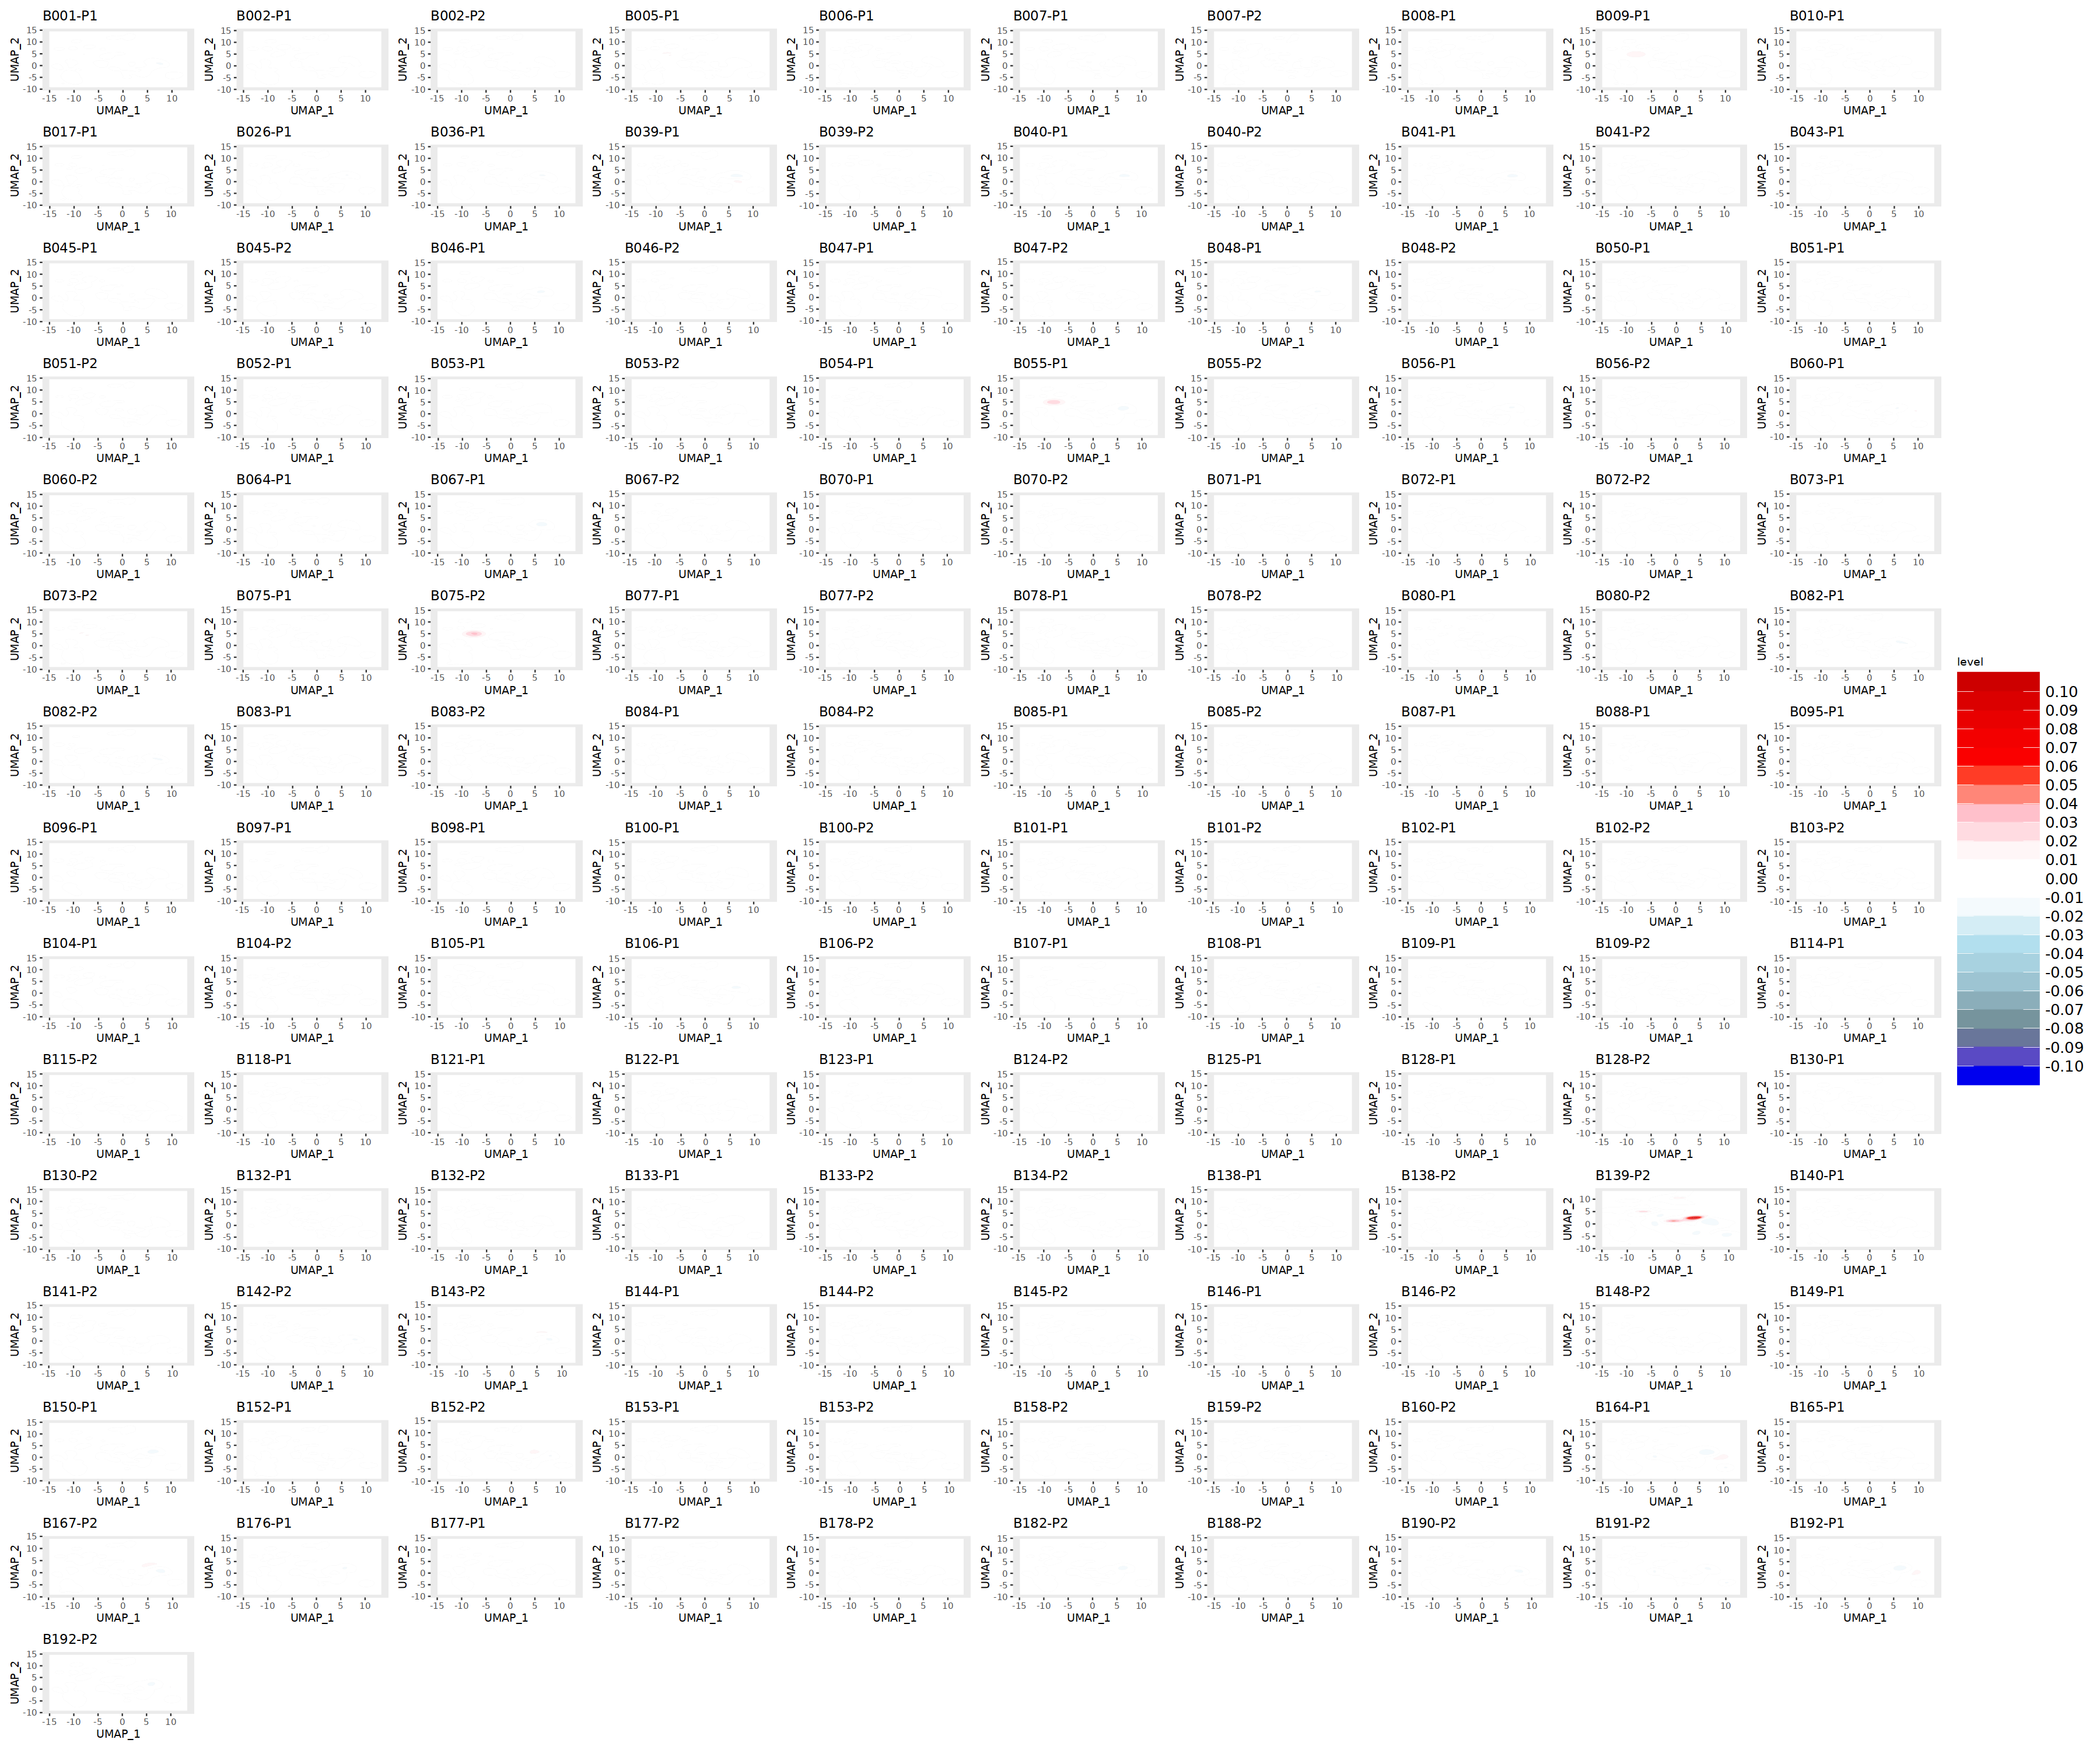

In [58]:
options(repr.plot.width = 30, repr.plot.height = 25)

wrap_plots(p,ncol=10)+plot_layout(guides = "collect")

# Compostition bar plot

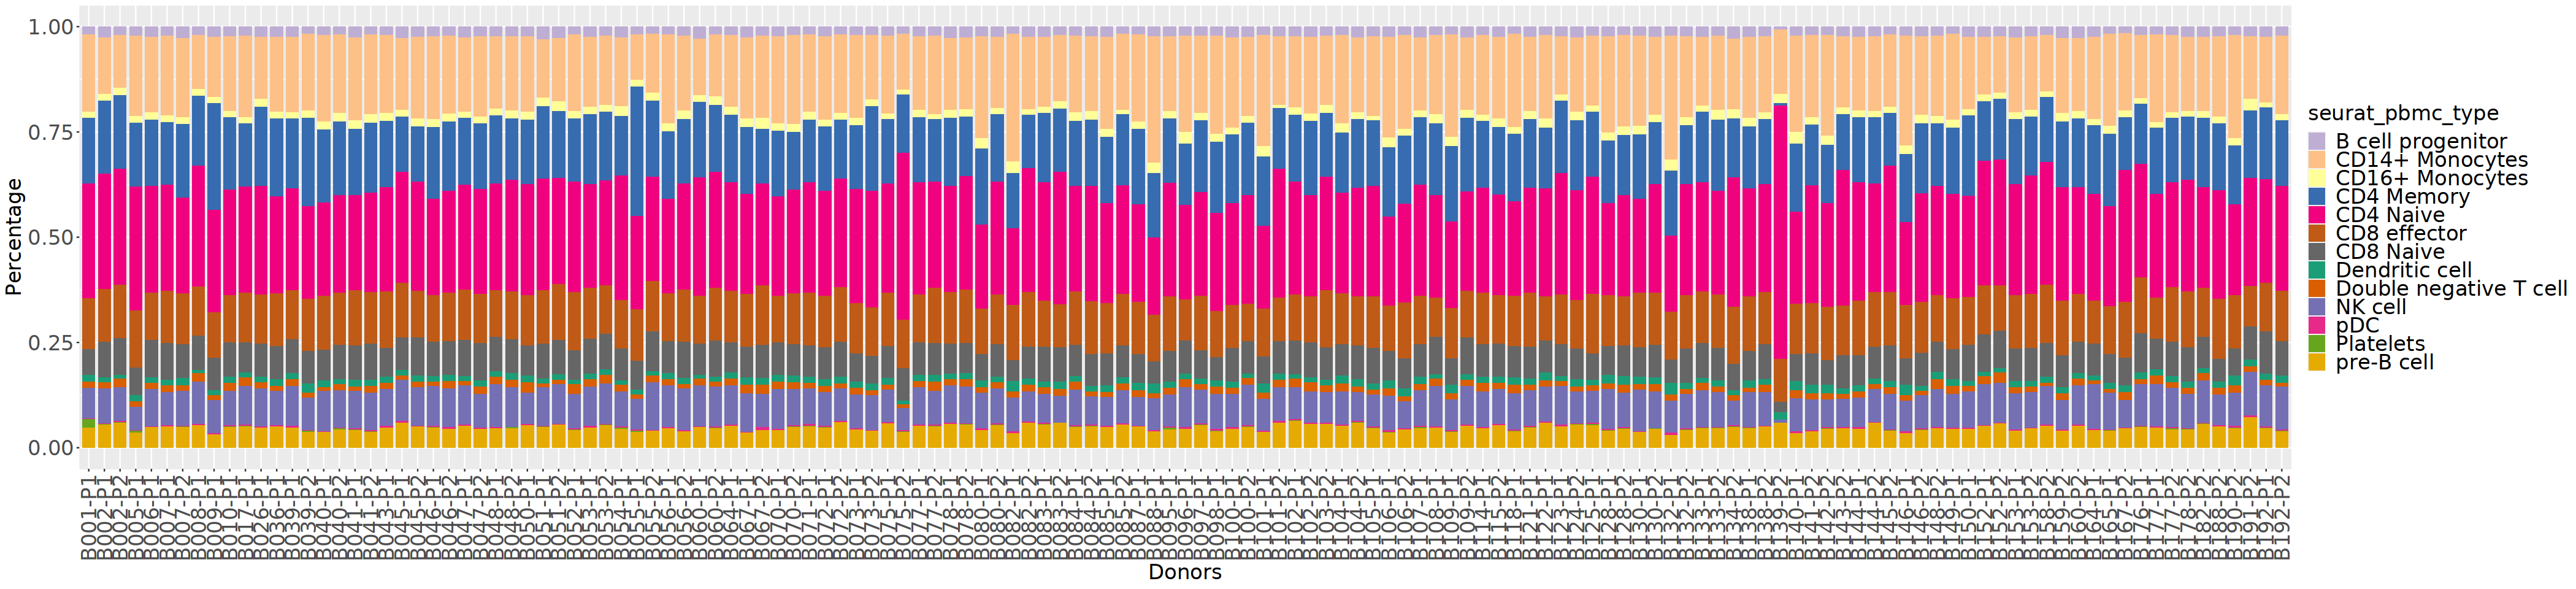

In [59]:
options(repr.plot.width = 35, repr.plot.height = 8)

p<-ggplot(data = combined[[]]) + 
  geom_bar(mapping = aes(x =pool_id, fill = seurat_pbmc_type), width = 0.8,position = "fill")+
  theme(axis.text = element_text(size = 20),axis.title = element_text(size = 20),axis.text.x=element_text(angle=90,hjust=1,vjust=0.5),
        legend.title = element_text(size=20), legend.text = element_text(size=20))+
  scale_fill_manual(values = col_vector[2:33])+  xlab("Donors") + ylab("Percentage")
p
ggsave("02_QC_CT_Compostion.png",p,width=35, height=10)

In [60]:
combined_subset<-subset(combined,subset=seurat_pbmc_type=='CD4 Naive')

In [61]:
combined_subset <- NormalizeData(object = combined_subset, normalization.method = "LogNormalize", 
    scale.factor = 10000)
combined_subset[["percent.mt"]] <- PercentageFeatureSet(combined_subset, pattern = "^MT-")

combined_subset <- subset(combined_subset, subset = nFeature_RNA > 200 & nFeature_RNA < 5000 & percent.mt < 10)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



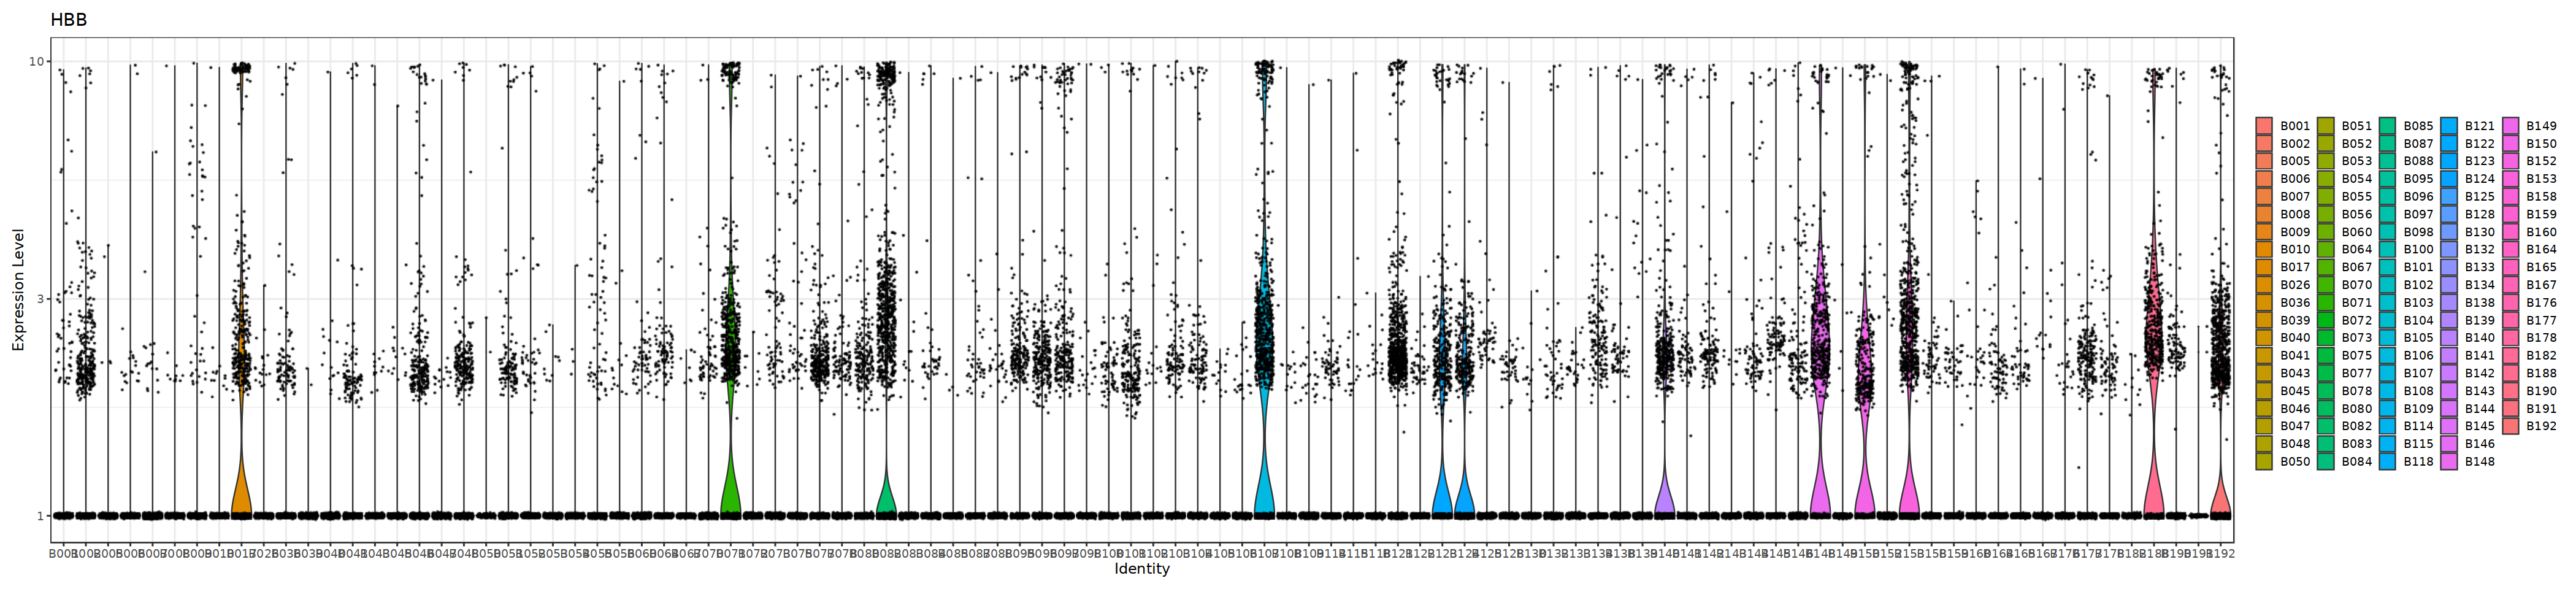

In [62]:
VlnPlot(combined_subset, features = c("HBB"), slot = "data",group.by='batch_id',log = TRUE)+theme_bw(base_size=14)